In [195]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from torchvision.datasets import MNIST

from tqdm.notebook import tqdm
from pathlib import Path
from typing import Iterator, Any, Optional
from dataclasses import dataclass, field
from PIL import Image

import matplotlib.gridspec as grd
import matplotlib.pyplot as plt
import cv2

import zipfile
import io
import random
import inspect

In [2]:
# config
plt.style.use('dark_background')

In [3]:
# constant
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DIR_DATASET = Path(r"G:").resolve() / "Dataset"

# for d in DIR_DATASET.iterdir():
#     print(d)


In [223]:
# dataclasses

@dataclass
class ZipData:
    index: int
    data: Any = field(repr=False)
    path: Path

In [297]:
def plotRGBLab(img_zipdata: ZipData):
    w, h = img_zipdata.data.shape[1] * 4 / 100, img_zipdata.data.shape[0] * 2 / 100
    w, h = max([w, 10]), max([h, 3])
    fig = plt.figure(figsize=(w, h))
    rows = 2
    grid = grd.GridSpec(nrows=rows, ncols=4, width_ratios=[3, 1, 1, 1])
    axes = [
        fig.add_subplot(grd.GridSpecFromSubplotSpec(nrows=rows, ncols=1, subplot_spec=grid[0:2, 0])[:, :]),

        fig.add_subplot(grd.GridSpecFromSubplotSpec(nrows=rows, ncols=1, subplot_spec=grid[0, 1])[:, :]),
        fig.add_subplot(grd.GridSpecFromSubplotSpec(nrows=rows, ncols=1, subplot_spec=grid[0, 2])[:, :]),
        fig.add_subplot(grd.GridSpecFromSubplotSpec(nrows=rows, ncols=1, subplot_spec=grid[0, 3])[:, :]),

        fig.add_subplot(grd.GridSpecFromSubplotSpec(nrows=rows, ncols=1, subplot_spec=grid[1, 1])[:, :]),
        fig.add_subplot(grd.GridSpecFromSubplotSpec(nrows=rows, ncols=1, subplot_spec=grid[1, 2])[:, :]),
        fig.add_subplot(grd.GridSpecFromSubplotSpec(nrows=rows, ncols=1, subplot_spec=grid[1, 3])[:, :]),
    ]
    @dataclass
    class PlotProp:
        title: str
        cmap: Optional[str] = "viridis"

    props = [
        PlotProp(title=f"{img_zipdata.data.shape} | {img_zipdata.path}"),

        PlotProp(title="R"),
        PlotProp(title="G"),
        PlotProp(title="B"),

        PlotProp(title="L"),
        PlotProp(title="a"),
        PlotProp(title="b"),

    ]
    props_idx = 0

    origin = axes.pop(0)
    origin.imshow(img_zipdata.data)
    origin.set_title(props[props_idx].title)
    origin.axis("off")

    for cvt in [None, cv2.COLOR_RGB2Lab]:
        converted = cv2.cvtColor(img_zipdata.data, cvt) if cvt else img_zipdata.data
        for s in cv2.split(converted):
            props_idx += 1
            ax = axes.pop(0)
            ax.axis("off")
            ax.set_title(props[props_idx].title)
            ax.imshow(s, cmap=props[props_idx].cmap)

    fig.tight_layout()
    plt.show()

In [298]:
def zip_loader(
        zip_path: Path, suffixes=["png", "jpg", "jpeg"], limit=None,
        shuffle=True, seed=None, loop=False,
        transform=lambda b: np.array(Image.open(io.BytesIO(b))),
        include_parts=None, exclude_parts=None
) -> tuple[int, Iterator[np.ndarray]]:
    zip_path = zip_path.resolve()

    for index, suffix in enumerate(suffixes.copy()):
        if not suffix.startswith("."):
            suffixes[index] = "." + suffixes[index]

    include_parts = include_parts or []
    exclude_parts = exclude_parts or []

    is_include = lambda rf: (len(include_parts) > 0 and (
                len(set(rf.parts) & set(include_parts)) > 0 or any([ip in str(rf) for ip in include_parts]))) or len(
        include_parts) == 0
    is_exclude = lambda rf: len(exclude_parts) > 0 and (
                len(set(rf.parts) & set(exclude_parts)) > 0 or any([ep in str(rf) for ep in exclude_parts]))

    with zipfile.ZipFile(zip_path, "r") as zf:

        zflist = [
            rf[0] for rf in [
                (f, Path(f.filename)) for f in zf.infolist()
            ] if (
                    (rf[1].suffix.lower() in suffixes)
                    and (is_include(rf[1]) and not is_exclude(rf[1]))
            )
        ]

        cnt = 0
        length = len(zflist)

        print(f"{'Loading from':<16}:", zip_path)
        print(f"{'Extract suffix':<16}:", suffixes)
        print(f"{'Include parts':<16}:", include_parts)
        print(f"{'Exclude parts':<16}:", exclude_parts)
        print(f"{'Shuffle':<16}:", shuffle)
        print(f"{'Loop':<16}:", loop)
        print(f"{'Limit':<16}:", limit)
        print(f"{'Seed':<16}:", seed)
        print(f"{'Data length':<16}:", length)
        print(f"{'Transform':<16}:", inspect.getsource(transform).strip().rstrip(",").split("=")[1])

        limit = limit or length

        if length == 0:
            return

        if shuffle:
            random.seed(seed)
            random.shuffle(zflist)

        with tqdm(zflist, total=limit or length) as t:
            while loop or cnt == 0:
                if (cnt >= limit):
                    break
                if shuffle:
                    random.seed(seed)
                    random.shuffle(zflist)

                for f in zflist:
                    if cnt >= limit:
                        break

                    cnt += 1
                    rf = Path(f.filename)
                    t.update(1)

                    with zf.open(f.filename) as bytes_data:
                        data = bytes_data.read()
                        if transform: data = transform(data)
                        yield ZipData(data=data, path=rf, index=cnt)

In [416]:
@dataclass
class View:
    input_view: np.ndarray = field(repr=False)# 画像
    distance: float
    view_limit_angle: np.ndarray = field(init=False) # (縦: (上, 下), 横: (左, 右))
    center: tuple[float, float] = (0, 0) # (縦, 横) (画像中心からの相対値)
    cv: int = field(init=False, repr=False, default=0)
    ch: int = field(init=False, repr=False, default=0)

    def __post_init__(self):
        self.cv, self.ch = int(self.input_view.shape[0] / 2 + self.center[0]), int(self.input_view.shape[1] / 2 + self.center[1])
        u, d, l, r = self.cv,  self.input_view.shape[0] - self.cv, self.ch,  self.input_view.shape[1] - self.ch
        self.view_limit_angle = np.degrees(np.arctan(np.array([[u, d],[l, r]]) / self.distance))

    def plot(self):
        plt.imshow(cv2.circle(self.input_view.copy(), (self.ch, self.cv), int(min(self.input_view.shape[0:2]) / 100), (255, 0, 0)))
        plt.show()


In [406]:
ZIP = DIR_DATASET /  "mscoco.zip" # "mscoco.zip"  # "cifar10.zip" # "open-images-v6.zip" # "cifar100.zip"
loader = zip_loader(ZIP, include_parts=["train"], exclude_parts=["annotations"])
# ZIP = DIR_DATASET /  "mnist.zip"
# loader = zip_loader(ZIP, include_parts=["train"], exclude_parts=["annotations"], transform=lambda b: cv2.cvtColor(np.array(Image.open(io.BytesIO(b))), cv2.COLOR_GRAY2RGB))

In [417]:
x = next(loader)

(640, 428, 3) mscoco\train2017\000000284989.jpg


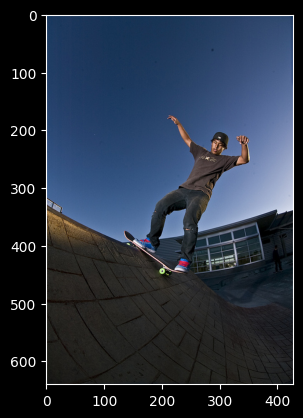

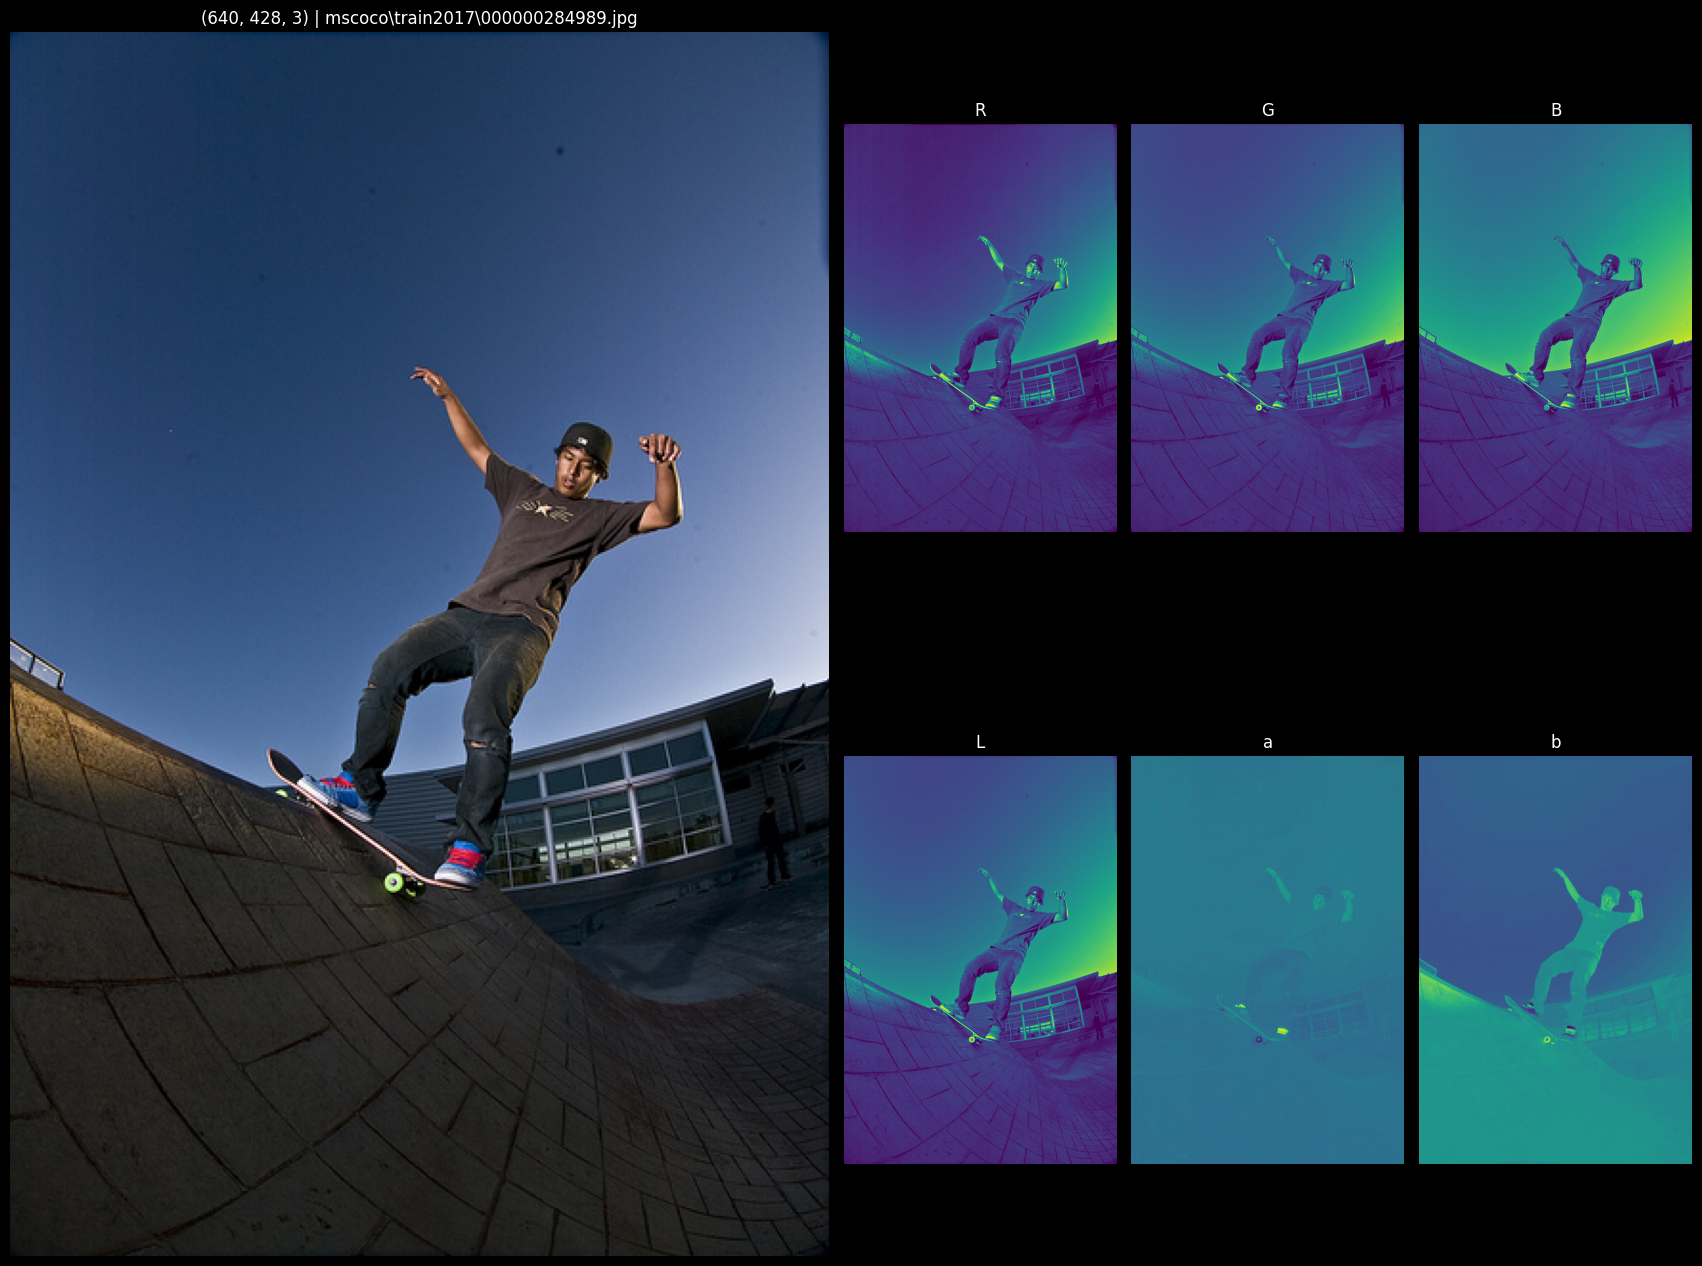

In [418]:
print(x.data.shape, x.path)
plt.imshow(x.data)
plt.show()
plotRGBLab(x)

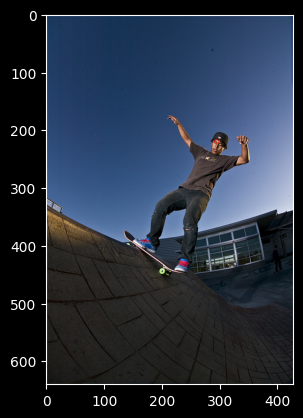

View(distance=1920, view_limit_angle=array([[ 6.53663365, 12.33908728],
       [ 8.70579418,  3.99229435]]), center=(-100, 80))

In [431]:
v = View(input_view=x.data, distance=1920, center=(-100, 80))
v.plot()
v

In [542]:
@dataclass
class ViewPoint:
    view: View
    view_center_angle: tuple[float, float] = (0, 0) # (縦, 横)
    view_radius: tuple[float, float] = (0.02, 0.02)

    def __post_init__(self):
        x, y = self.view_center_angle
        (lu, ld), (ll, lr) = self.view.view_limit_angle
        print(f"{-ll} <= x <= {lr},  {-ld} <= y <= {lu}")
        assert -ll <= x <= lr and -ld <= y <= lu, f"Angle Error, 'view_center_angle' limit {-ll} <= x <= {lr},  {-ld} <= y <= {lu}"

    def convert(self):
        x, y = np.tan(np.radians(self.view_center_angle)) * self.view.distance
        x, y = x, -y
        print(x, y,  (self.view.ch, self.view.cv), (int(self.view.ch + x), int(self.view.cv + y)))
        v = cv2.circle(self.view.input_view.copy(), (int(self.view.ch + x), int(self.view.cv + y)), int(min(self.view.input_view.shape[0:2]) / 100), (255, 255, 0), thickness=16)
        plt.imshow(v)
        plt.show()


-8.705794176576426 <= x <= 3.9922943520037535,  -12.339087278326195 <= y <= 6.536633648797066


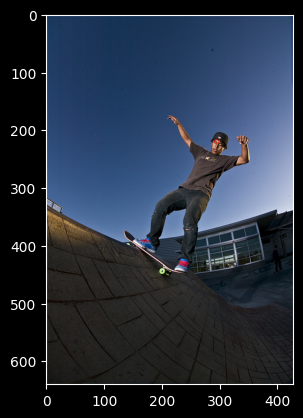

67.04787742415564 338.54780296025274 (294, 220) (361, 558)


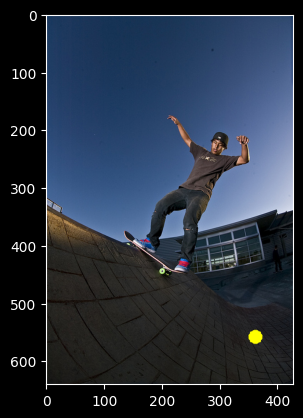

In [543]:
vp = ViewPoint(view=v, view_center_angle=(2, -10))
v.plot()
vp.convert()